In [1]:
%load_ext notexbook

%texify -fs 18

# Modelling Air Pollution

In [2]:
import numpy as np
import pandas as pd
import statsmodels as sm

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression

from statsmodels.tsa import api as smt
from statsmodels.tsa.stattools import adfuller

RANDOM_SEED = 123456
np.random.seed(RANDOM_SEED)
plt.style.use('bmh')

In [3]:
air_pollution = pd.read_csv('air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [4]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


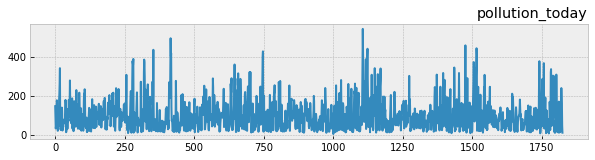

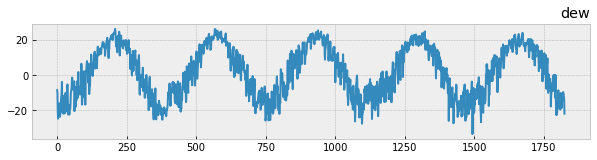

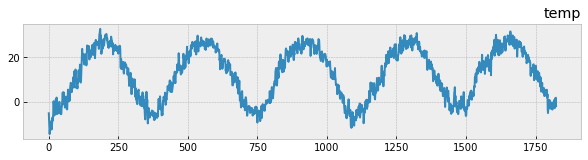

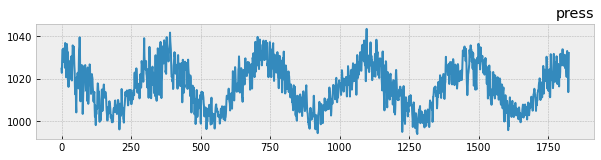

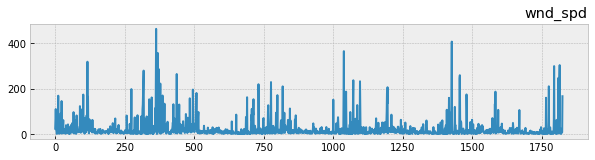

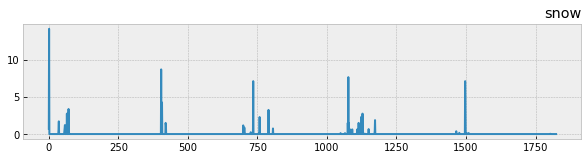

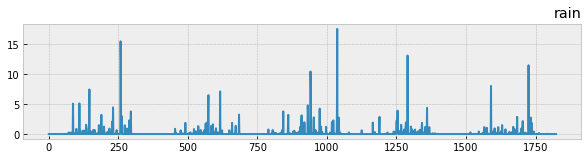

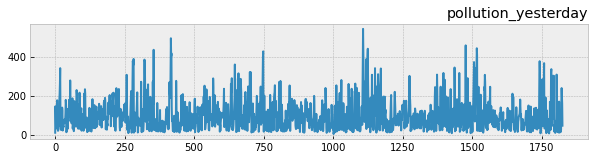

In [5]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1

# plot each column
for group in groups:
    plt.figure(figsize=(10, 20))
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=1, loc='right')
    i += 1


plt.show()

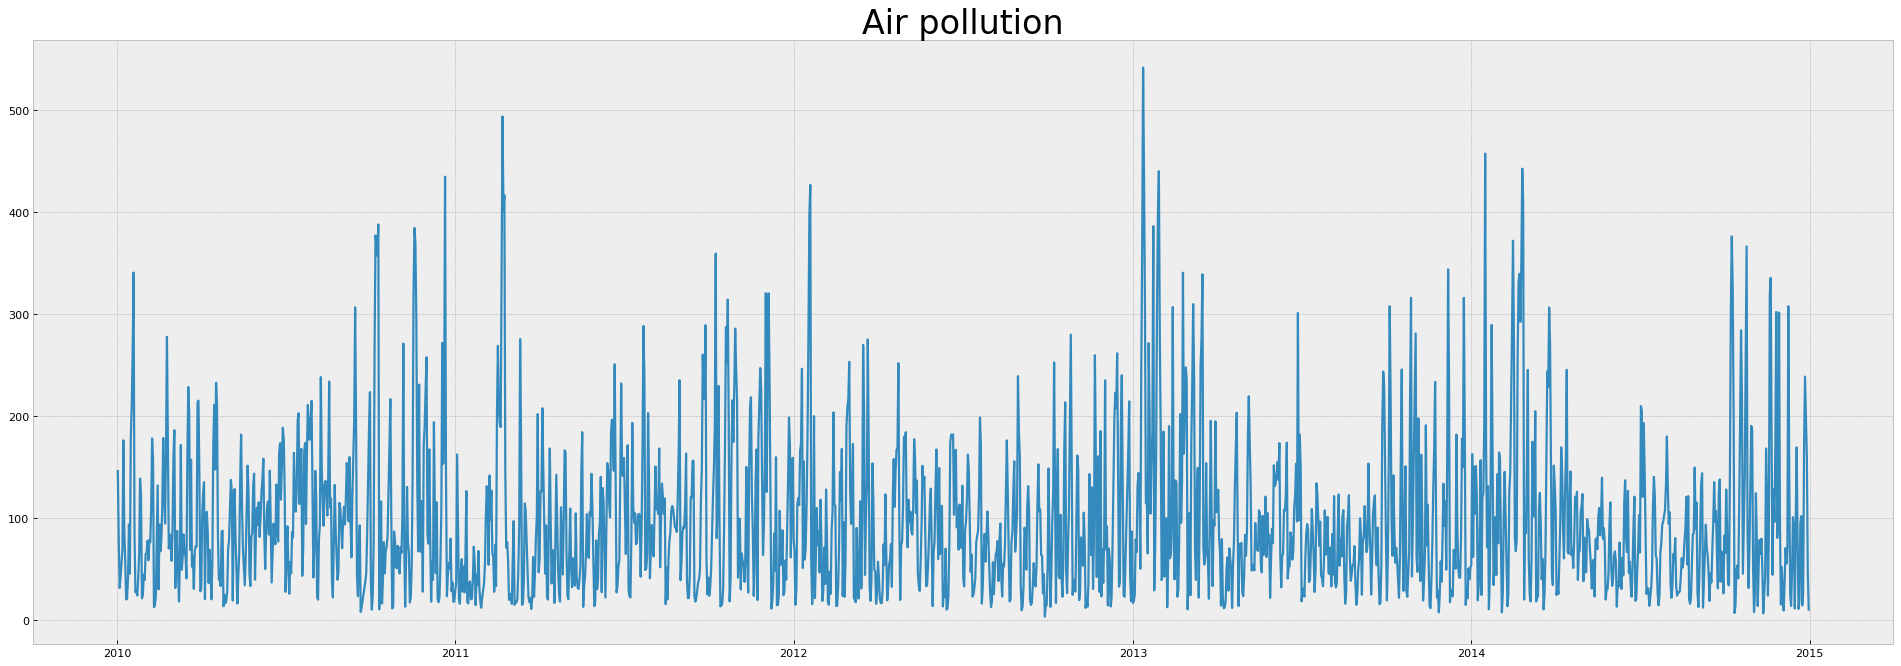

In [6]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(air_pollution.pollution_today)
plt.show()

## Decomposing our time series

One of the most common analysis for time series is **decomposing it into multiple parts**. 

The parts we can divide a time series into are: `level`, `trend`, `seasonality` and `noise`, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

#### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. 

Trend is linear and seasonality has constant frequency and amplitude. 

Change is constant over time

#### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are **nonlinear**, trend is curved and seasonality is not constant. Change is not constant over time

#### Automatic time series decomposition

Decomposition is used to analyse the time series. 

Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

`statsmodel` provides a [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function to **automatically decompose** a time series, you still need to specify wether the model is additive or multiplicative. 

We will use multiplicative as our quick peak at the `pm2.5` time series shows no linear trend.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

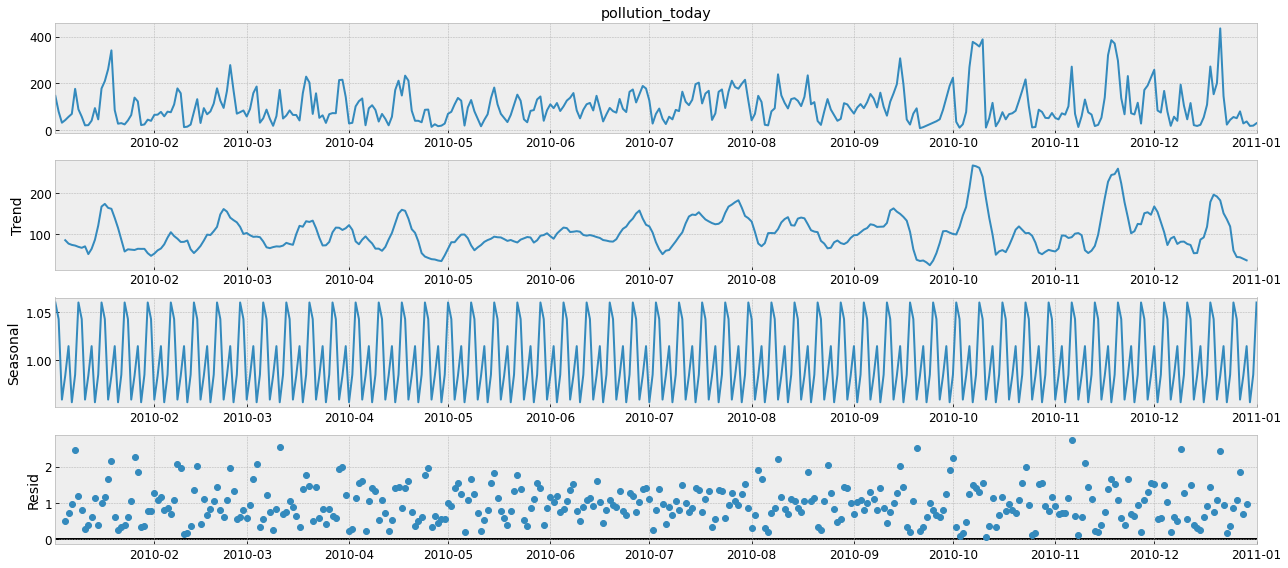

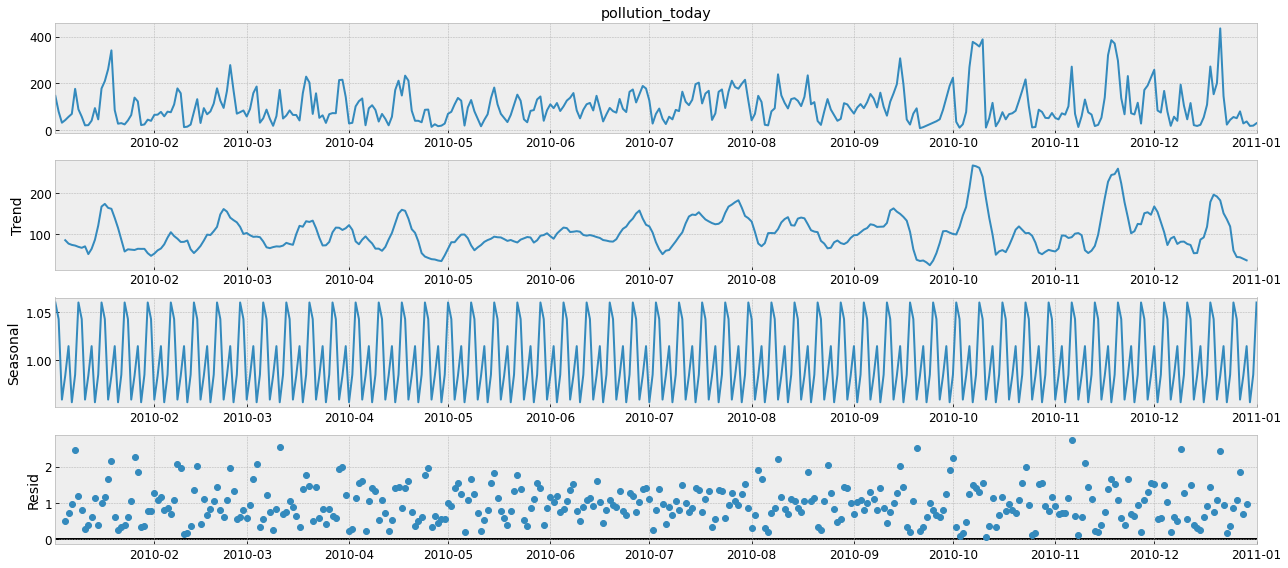

In [8]:
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

#### Level

**Level** simply refers to the current value of the series once we remove **trend**, **seasonality** and the **random noise**. 

This are the true values that come from the series itself and we will try to predict with our models.

**Note**: Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. 

#### Trend

A **trend** is observed when there is an increasing or decreasing slope observed in the time series.

Trend can be removed from your time series data as a data preparation and cleaning process. 

This is beneficial when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. 

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend

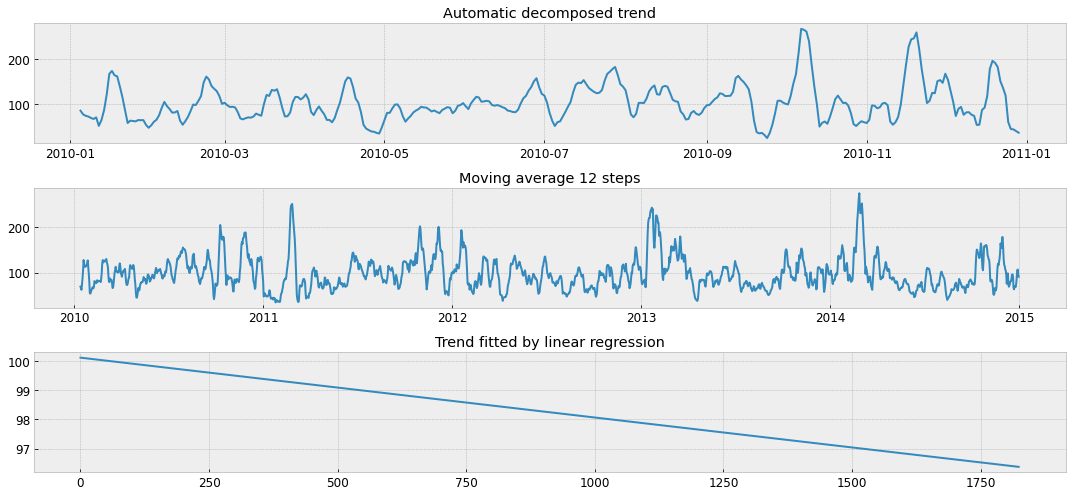

In [9]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)  # automatic deomposition trend
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a `seasonality effect + random noise` than a `trend`. 

This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

#### Seasonality

Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. 

It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sunscream protector (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

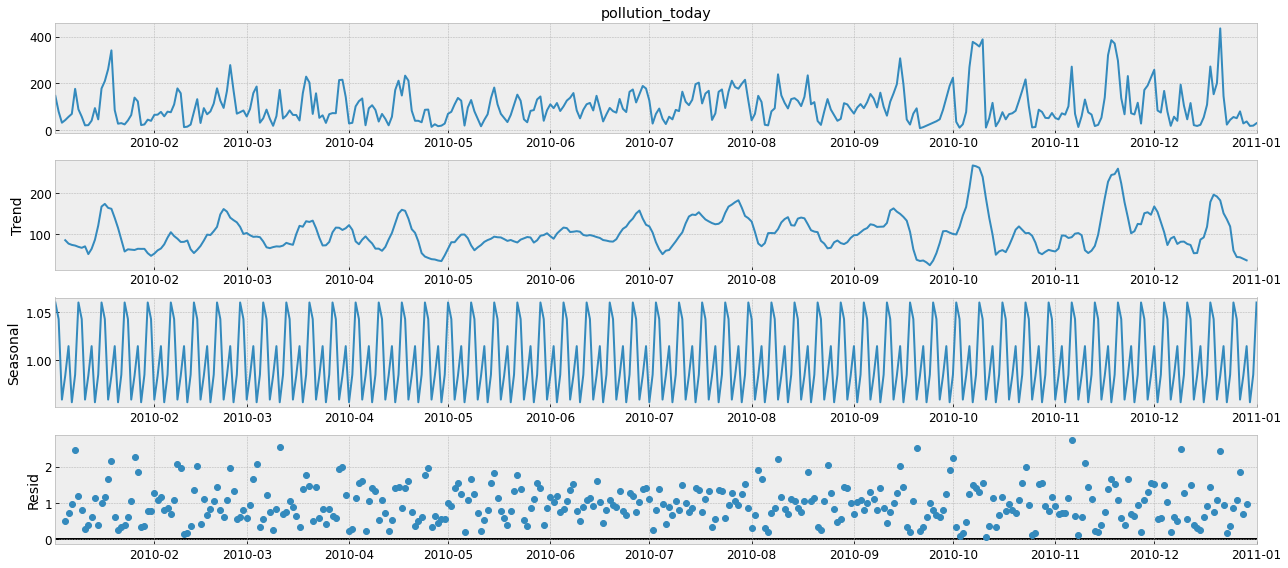

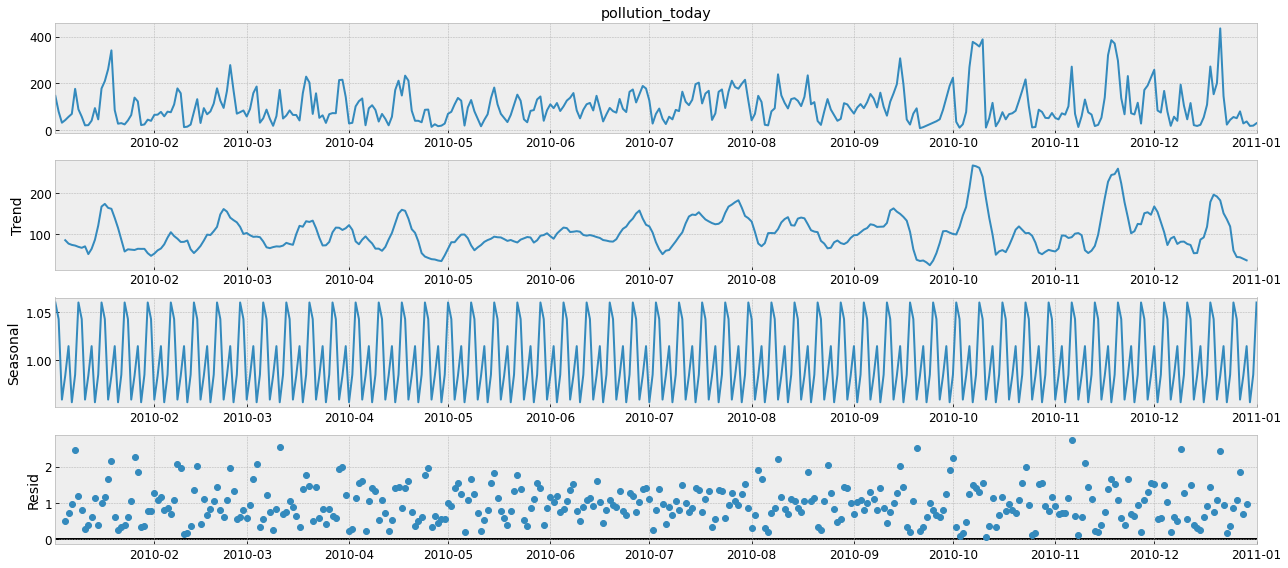

In [10]:
mpl.rcParams['figure.figsize'] = 18, 8
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

Here can see a clear weekly trend, 4 spikes every month (weerkly). Lets check how the last year of data looks

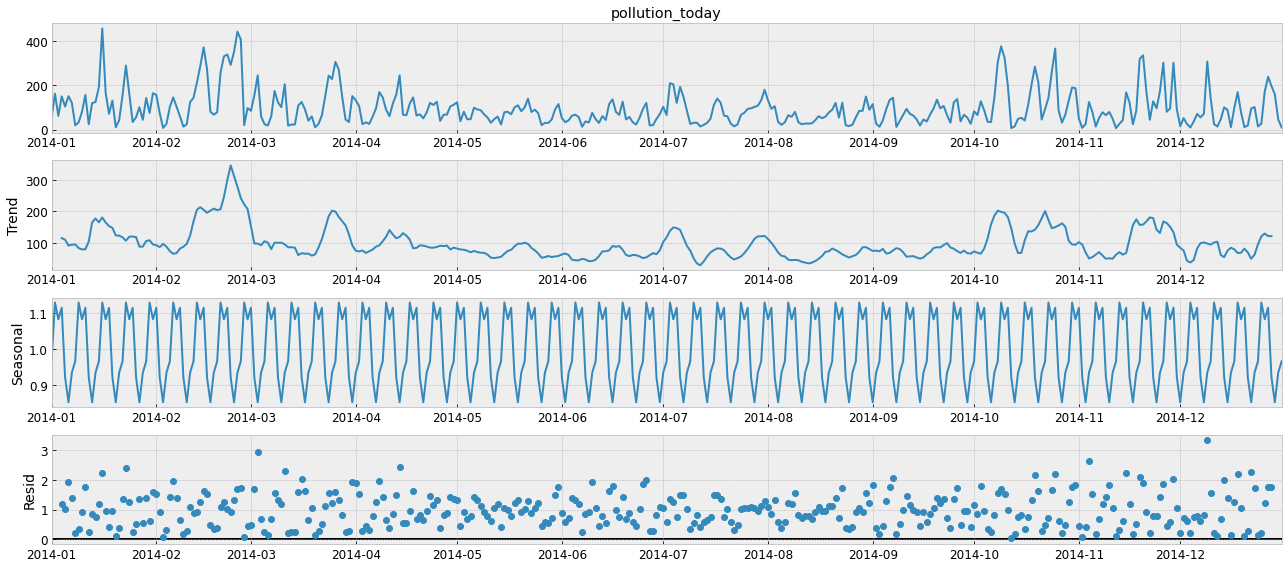

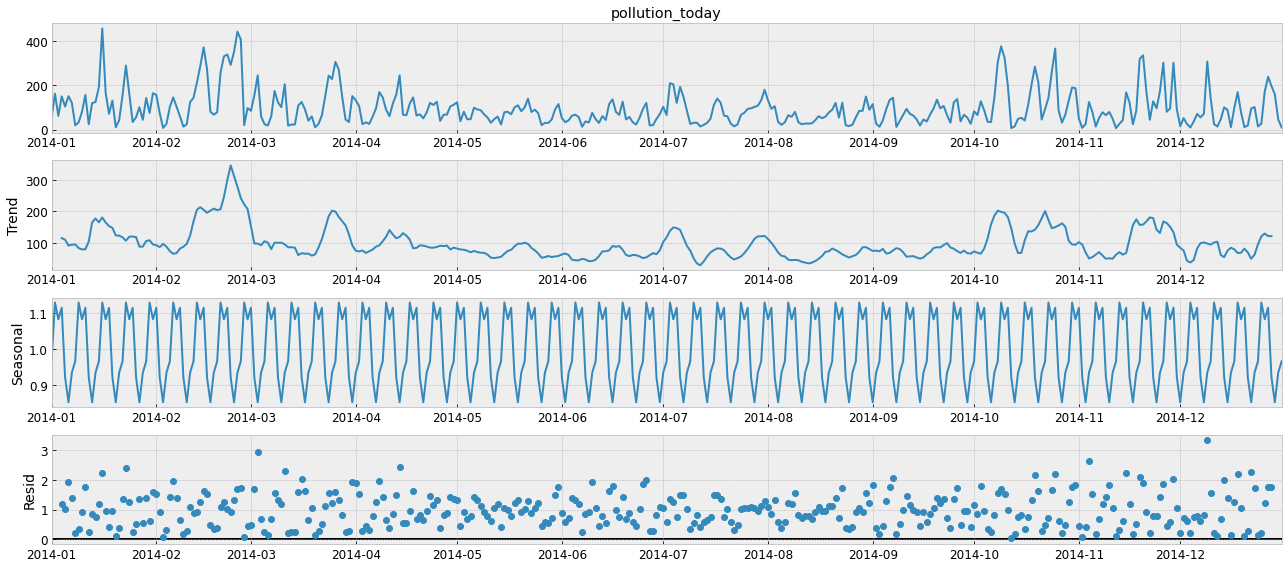

In [11]:
mpl.rcParams['figure.figsize'] = 18, 8
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

We see another weekly seasonality (**4 spikes between every month**) but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples.

##### Interpretation

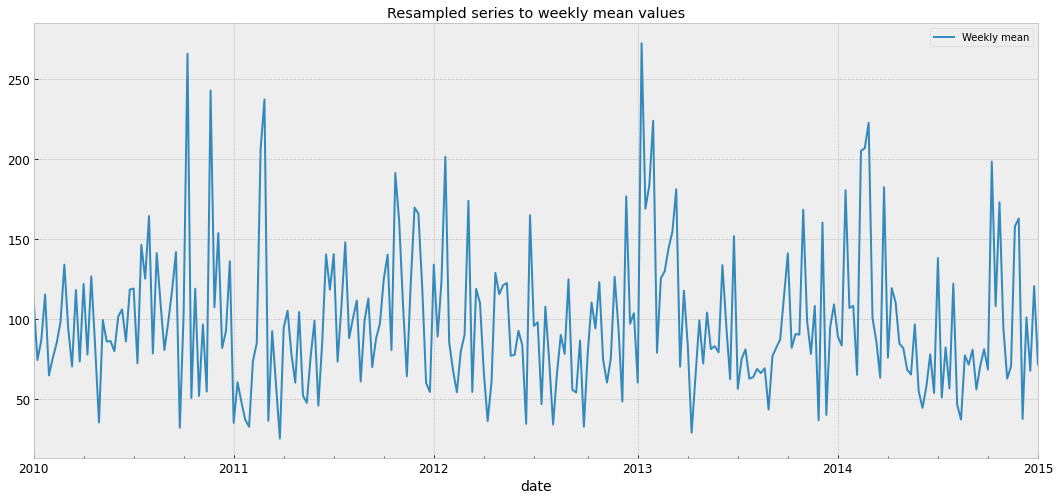

In [12]:
# Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()
plt.show()

We can see how the model to find a seasonality fits poorly to our data. 

Is going to be a complicate time series to model 😬

#### Noise

Our time series will also have a noise component to them, most likely [white noise](https://en.wikipedia.org/wiki/White_noise). 

We say white noise is present if the measurement are independent and identically distributed with a mean of zero. 

This will mean **all our measurements** have same variance and **no correlation with the rest of values in the series**.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std

* AutoCorrelation plots

* Standard deviation distribution, is it a Gaussian distribution?

* Does the mean or level change over time?

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'Mean over time')

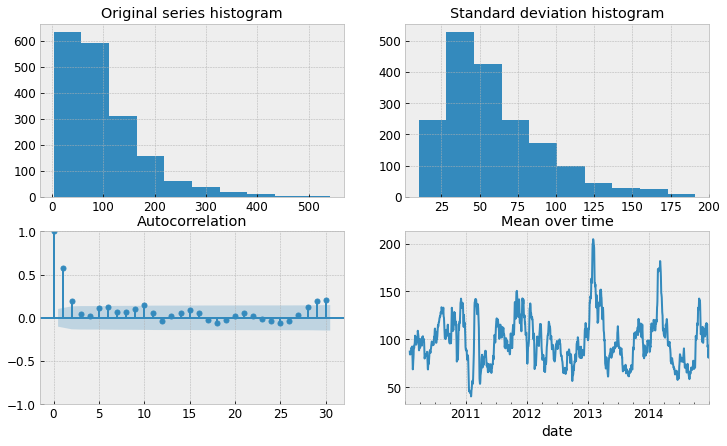

In [14]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

# Original Histogram
air_pollution.pollution_today.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

# autocorrelation
plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = air_pollution.pollution_today.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution_today.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


We can see our series do not follow a **Gaussian distribution** from the histogram.

We also have a small correlation with close measurements in time but not present with distant measurements (this could also indicate low seasonality). 

The `mean over time` also shows something similar with a constant value and high peaks in the same moments for the 4 years (smaller in 2012)

We could say our series does contain a small part of white noise but it is really small and hard to remove

#### Stationarity

**recap**: A time series is stationarity if it has constant mean and variance over time. 

Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.


#### Check for sationarity

##### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time $t+1,t+2,..t+n$. 

If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

/Users/valerio/anaconda3/envs/webvalley/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


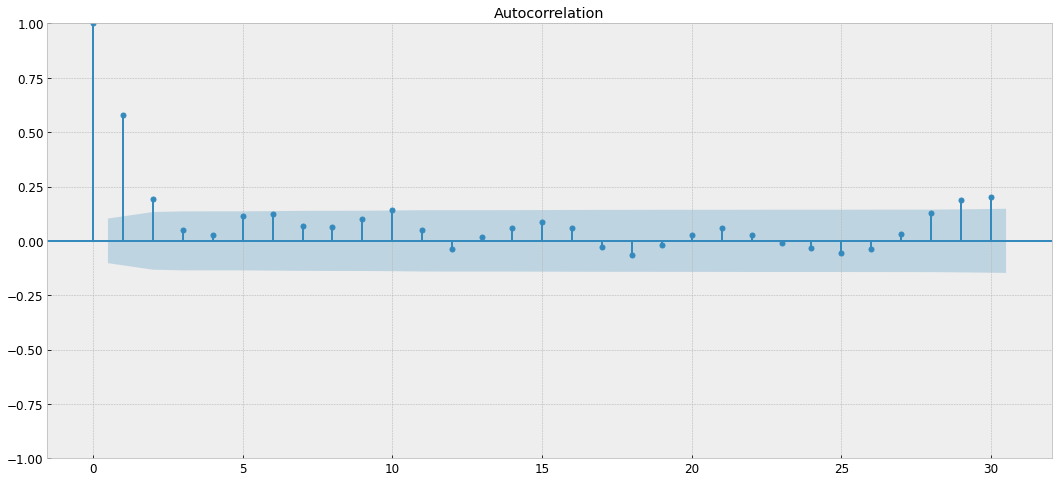

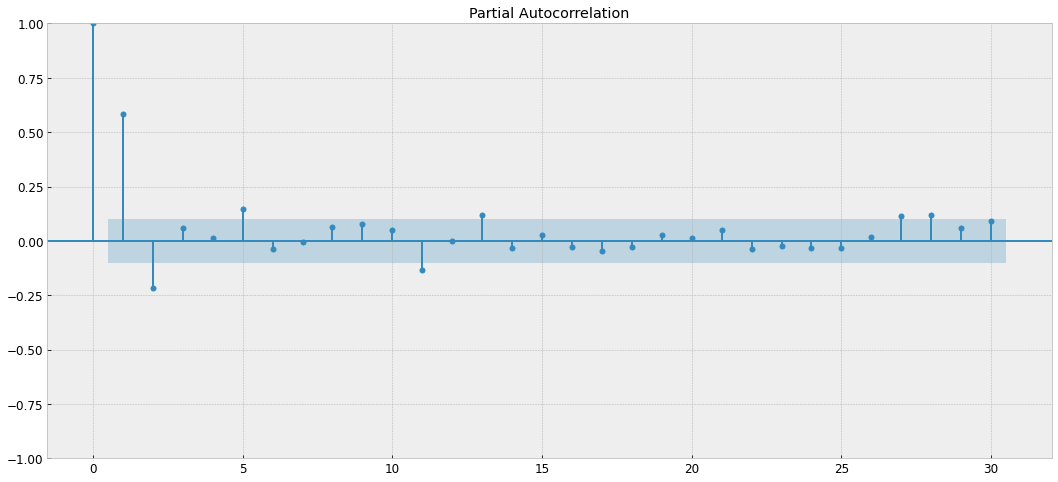

In [15]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

#### Augmented Dickey-Fuller test

**recap** The Dickey-Fuller test is a type of statistical test called a unit root test. 

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- `p-value > 0.05`: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- `p-value <= 0.05`: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [16]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :)

/Users/valerio/anaconda3/envs/webvalley/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


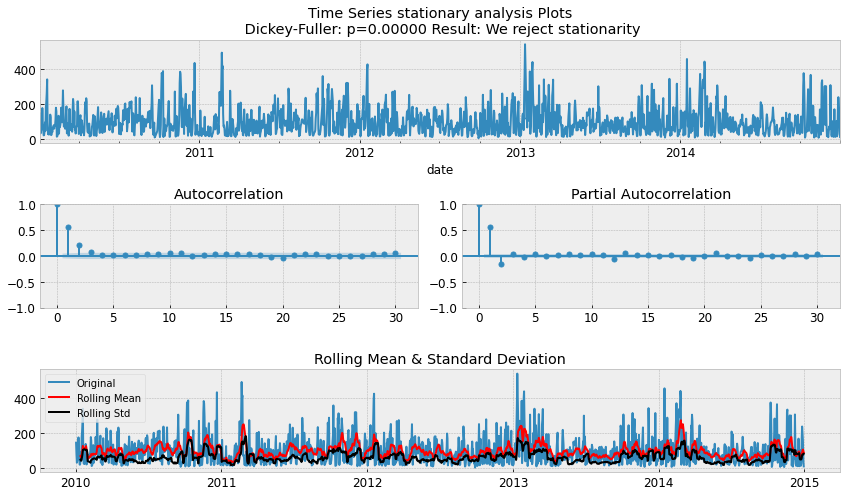

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(air_pollution.pollution_today, lags=30)